MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -8 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [6]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [8]:
# Step 1: Define the wellbeing columns
wellbeing_items = ['SATIS', 'WORTH', 'HAPPY']

# Step 2: Drop rows where all three are invalid (-8 or -9)
invalid_mask = (df[wellbeing_items] <= -8).all(axis=1)
df = df[~invalid_mask].copy()

# Step 3: Replace -8 and -9 with NaN temporarily to compute column means
temp = df[wellbeing_items].replace({-8: np.nan, -9: np.nan})

# Step 4: Compute column means (excluding -8/-9)
col_means = temp.mean()

# Print the column means
print("\nColumn means (excluding -8 and -9):")
print(col_means)

# Step 5: Replace -8 and -9 with their respective column means
for col in wellbeing_items:
    df[col] = df[col].replace({-8: col_means[col], -9: col_means[col]})

# Step 6: Compute Wellbeing score as row-wise average
df['Wellbeing'] = df[wellbeing_items].mean(axis=1)

# Optional: Preview
print("\nSample of cleaned data:")
print(df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head())


Column means (excluding -8 and -9):
SATIS    7.553688
WORTH    7.856793
HAPPY    7.509492
dtype: float64

Sample of cleaned data:
   SATIS  WORTH  HAPPY  Wellbeing
0    8.0    8.0    7.0   7.666667
1   10.0    8.0   10.0   9.333333
2   10.0    9.0   10.0   9.666667
4    8.0    5.0    8.0   7.000000
5    8.0    8.0    7.0   7.666667


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [10]:
# Replace missing codes in Wellbeing column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)

def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score < 8:
        return 'Low'   
    else:
        return 'High'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)


# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,Low,7.0,High
1,9.333333,High,0.0,Very low
2,9.666667,High,0.0,Very low
4,7.000000,Low,1.0,Very low
5,7.666667,Low,2.0,Low


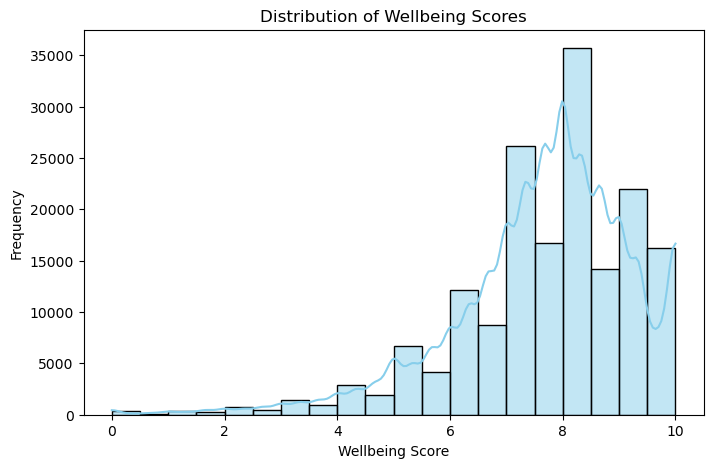


Summary statistics for Wellbeing:
count    172333.000000
mean          7.637979
std           1.601086
min           0.000000
25%           7.000000
50%           8.000000
75%           8.666667
max          10.000000
Name: Wellbeing, dtype: float64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram + KDE for numeric Wellbeing scores
plt.figure(figsize=(8, 5))
sns.histplot(df['Wellbeing'].dropna(), kde=True, bins=20, color='skyblue')
plt.title('Distribution of Wellbeing Scores')
plt.xlabel('Wellbeing Score')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
print("\nSummary statistics for Wellbeing:")
print(df['Wellbeing'].describe())

In [12]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing              848
Wellbeing_category     848
ANXIOUS               1085
Anxiety_category      1085
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [14]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In [15]:
category_order = {
    'Low': 0,
    'High': 1
}
cleaned = cleaned.copy()
cleaned['Wellbeing_category_num'] = cleaned['Wellbeing_category'].map(category_order)

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [17]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [18]:
# Select numeric columns
numeric_cols = cleaned.select_dtypes(include='number').columns.drop('Wellbeing_category_num')

# Remove columns with zero variance
numeric_cols = [col for col in numeric_cols if cleaned[col].std() > 0]

# Calculate correlation
corr_with_target = cleaned[numeric_cols].corrwith(cleaned['Wellbeing_category_num'])

# Top 20
top_20 = corr_with_target.abs().sort_values(ascending=False).head(20)

print("Top 20 features most correlated with Wellbeing_category_num:")
print(top_20)

Top 20 features most correlated with Wellbeing_category_num:
Wellbeing    0.745596
HAPPY        0.665465
SATIS        0.637566
WORTH        0.611846
REDACT       0.164984
MARCHK       0.163201
MARDY6       0.157024
XDISDDA20    0.156713
LIMITA       0.134050
LIMITK       0.133979
TEN1         0.126008
TIED         0.116373
FURN         0.115884
DISBEN1      0.114439
LLORD        0.109715
START        0.106303
LIMACT       0.100993
MF5964       0.094663
TPBN1302     0.093738
AAGE         0.091487
dtype: float64


In [19]:
import numpy as np

# Define mapping
aage_to_avg = {
    2.0: 17,  # 16-17
    3.0: 19,  # 18-19
    4.0: 22,    # 20-24
    5.0: 27,    # 25-29
    6.0: 32,    # 30-34
    7.0: 37,    # 35-39
    8.0: 42,    # 40-44
    9.0: 47,    # 45-49
    10.0: 52,   # 50-54
    11.0: 57,   # 55-59
    12.0: 62,   # 60-64
    13.0: 82    # 65-99
}

# Apply mapping 
cleaned['AGE'] = cleaned['AAGE'].map(aage_to_avg)

# Map GOR9d to numeric codes
region_map = {
    'E12000001': 1,  # North East
    'E12000002': 2,  # North West
    'E12000003': 3,  # Yorkshire and The Humber
    'E12000004': 4,  # East Midlands
    'E12000005': 5,  # West Midlands
    'E12000006': 6,  # East of England
    'E12000007': 7,  # London
    'E12000008': 8,  # South East
    'E12000009': 9,  # South West
    'L99999999': 10, # Channel Islands (pseudo)
    'M99999999': 11, # Isle of Man (pseudo)
    'N99999999': 12, # Northern Ireland
    'S99999999': 13, # Scotland (pseudo)
    'W99999999': 14  # Wales (pseudo)
}

# Apply the mapping to create a new column
cleaned['GOR9d_num'] = cleaned['GOR9d'].map(region_map)

# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype and replace -8 with NaN (keep -9)
cleaned[health_cols] = cleaned[health_cols].astype('Int64').replace(-8, np.nan)

# Step 3: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 4: Efficient one-pass creation of HEALTH_* columns
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'

    if col_name not in cleaned.columns:
        # Use vectorized comparison and any across the row
        cleaned[col_name] = (cleaned[health_cols] == code).any(axis=1).astype(int)

print("Optimized HEALTH columns created.")

Optimized HEALTH columns created.


In [20]:
cleaned.to_csv("cleaned.csv", index=False)

In [21]:
import pandas as pd
cleaned = pd.read_csv("cleaned.csv",low_memory=False)

## **Data exploration**


In [23]:
# Dictionary
feature_labels = {
    # SEX
    'SEX_1': 'Male',
    'SEX_2': 'Female',

    # ETHUKEUL (Ethnicity)
    'ETHUKEUL_1.0': 'White',
    'ETHUKEUL_2.0': 'Mixed/Multiple ethnic groups',
    'ETHUKEUL_3.0': 'Indian',
    'ETHUKEUL_4.0': 'Pakistani',
    'ETHUKEUL_5.0': 'Bangladeshi',
    'ETHUKEUL_6.0': 'Chinese',
    'ETHUKEUL_7.0': 'Any other Asian background',
    'ETHUKEUL_8.0': 'Black/African/Caribbean/Black British',
    'ETHUKEUL_9.0': 'Other ethnic group',

    # MARDY6 (Marital status)
    'MARDY6_1': 'Married/Cohabiting/Civil Partner',
    'MARDY6_2': 'Non-married',

    # ILODEFR (Economic activity)
    'ILODEFR_1': 'In employment',
    'ILODEFR_2': 'ILO unemployed',
    'ILODEFR_3': 'Inactive',

    # TEN1 (Accommodation details)
    'TEN1_1.0': 'Owned outright',
    'TEN1_2.0': 'Being bought with mortgage or loan',
    'TEN1_3.0': 'Part rent, part mortgage',
    'TEN1_4.0': 'Rented',
    'TEN1_5.0': 'Rent free or squatted',
    'TEN1_6.0': 'Squatting',

    # XDISDDA20 (Unadjusted DDA disabled)
    'XDISDDA20_-9': 'Does not apply',
    'XDISDDA20_1': 'Current disability only',
    'XDISDDA20_2': 'Current and past disabled',
    'XDISDDA20_3': 'Past disability only',
    'XDISDDA20_4': 'Not DDA disabled',

    # LEVQUL22 (RQF Level of highest qualification)
    'LEVQUL22_-9': 'Does not apply',
    'LEVQUL22_1': 'RQF Level 8 (Doctorate)',
    'LEVQUL22_2': 'RQF Level 7 (Master’s)',
    'LEVQUL22_3': 'RQF Level 6 (Bachelor’s)',
    'LEVQUL22_4': 'RQF Level 5 (HND/Foundation Degree)',
    'LEVQUL22_5': 'RQF Level 4 (CertHE)',
    'LEVQUL22_6': 'RQF Level 3 (A-Levels)',
    'LEVQUL22_7': 'RQF Level 2 (GCSE A*-C)',
    'LEVQUL22_8': 'RQF Level 1 (GCSE D-G)',
    'LEVQUL22_9': 'RQF Entry Level',
    'LEVQUL22_10': 'Other Qualifications',
    'LEVQUL22_11': 'No Qualifications',
    'LEVQUL22_12': 'Don’t Know (Qualification)',

    # INDE07M (Industry sector in main job)
    'INDE07M_-9.0': 'Does not apply',
    'INDE07M_1.0': 'Agriculture, forestry and fishing',
    'INDE07M_2.0': 'Energy and water',
    'INDE07M_3.0': 'Manufacturing',
    'INDE07M_4.0': 'Construction',
    'INDE07M_5.0': 'Distribution, hotels and restaurants',
    'INDE07M_6.0': 'Transport and communication',
    'INDE07M_7.0': 'Banking and finance',
    'INDE07M_8.0': 'Public admin, education and health',
    'INDE07M_9.0': 'Other services',

    # RELIG11 (Religion)
    'RELIG11_1.0': 'No Religion',
    'RELIG11_2.0': 'Christian',
    'RELIG11_3.0': 'Buddhist',
    'RELIG11_4.0': 'Hindu',
    'RELIG11_5.0': 'Jewish',
    'RELIG11_6.0': 'Muslim',
    'RELIG11_7.0': 'Sikh',
    'RELIG11_8.0': 'Other Religion',

    # GOR9d (Region)
    'GOR9d_num_1': 'North East',
    'GOR9d_num_2': 'North West',
    'GOR9d_num_3': 'Yorkshire and The Humber',
    'GOR9d_num_4': 'East Midlands',
    'GOR9d_num_5': 'West Midlands',
    'GOR9d_num_6': 'East of England',
    'GOR9d_num_7': 'London',
    'GOR9d_num_8': 'South East',
    'GOR9d_num_9': 'South West',
    'GOR9d_num_10': '(pseudo) Channel Islands',
    'GOR9d_num_11': '(pseudo) Isle of Man',
    'GOR9d_num_12': 'Northern Ireland',
    'GOR9d_num_13': '(pseudo) Scotland',
    'GOR9d_num_14': '(pseudo) Wales',

    # HEALTH binary indicators
    'HEALTH_Diabetes': 'Diabetes',
    'HEALTH_MentalAnxiety': 'Mental Anxiety',
    'HEALTH_ArmsOrHands': 'Arms/Hands Disability',
    'HEALTH_LegsOrFeet': 'Legs/Feet Disability',
    'HEALTH_BackOrNeck': 'Back/Neck Disability',
    'HEALTH_MentalIllness': 'Mentai Illness',
    'HEALTH_Autism': 'Autism',
    'HEALTH_ProgressiveIllness': 'ProgressiveIllness',
    'HEALTH_HeartOrCirculation': 'HeartOrCirculation',
    'NATIDB11': 'British Identity',
}

In [24]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE

# --- Feature Groups ---
columns = {
    'AGE': 'AGE',
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'XDISDDA20',
    'QUALIFICATION': 'LEVQUL22',
    'Job_Sector': 'INDE07M',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d_num',
    'DIABETES': 'HEALTH_Diabetes',
    'MentalAnxiety': 'HEALTH_MentalAnxiety',
    'ArmsDisability': 'HEALTH_ArmsOrHands',
    'LegsDisability': 'HEALTH_LegsOrFeet',
    'BackDisability': 'HEALTH_BackOrNeck',
   'MentalIllness': 'HEALTH_MentalIllness',
   'Autism': 'HEALTH_Autism',
    'ProgressiveIllness': 'HEALTH_ProgressiveIllness',
    'HeartOrCirculation': 'HEALTH_HeartOrCirculation'
}

nominal_cols = [
    'LEVQUL22', 'ILODEFR', 'MARDY6', 'SEX',
    'TEN1', 'XDISDDA20', 'INDE07M','GOR9d_num','ETHUKEUL','RELIG11'
]

binary_cols = [
    'NATIDB11','HEALTH_MentalAnxiety', 'HEALTH_Diabetes', 
    'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 
    'HEALTH_BackOrNeck','HEALTH_MentalIllness','HEALTH_Autism',
    'HEALTH_ProgressiveIllness', 'HEALTH_HeartOrCirculation'
]

continuous_cols = ['AGE']

print("Imports and column groups loaded.")

Imports and column groups loaded.


In [25]:
# Combine all columns to check
all_columns = list(columns.values())

# Check missing values for these columns
missing_counts = cleaned[all_columns].isna().sum()

print("Missing values count per column:")
print(missing_counts)

Missing values count per column:
AGE                             0
SEX                             0
ETHUKEUL                       75
NATIDB11                       62
MARDY6                          0
ILODEFR                         0
TEN1                           97
XDISDDA20                       0
LEVQUL22                        0
INDE07M                       142
RELIG11                      9350
GOR9d_num                       0
HEALTH_Diabetes                 0
HEALTH_MentalAnxiety            0
HEALTH_ArmsOrHands              0
HEALTH_LegsOrFeet               0
HEALTH_BackOrNeck               0
HEALTH_MentalIllness            0
HEALTH_Autism                   0
HEALTH_ProgressiveIllness       0
HEALTH_HeartOrCirculation       0
dtype: int64


In [26]:
# --- Step 1: Clean and prepare base dataframe ---
relevant_cols = list(columns.values()) + ['Wellbeing_category_num']
model_df = cleaned[relevant_cols].copy().dropna()

X = model_df[list(columns.values())].copy()
y = model_df['Wellbeing_category_num'].copy()

X[binary_cols] = X[binary_cols].astype(int)
X[nominal_cols] = X[nominal_cols].astype('category')
X[continuous_cols] = X[continuous_cols].apply(pd.to_numeric, errors='coerce')

# --- Step 2: One-hot encode nominal columns ---
X_nominal = pd.get_dummies(X[nominal_cols], drop_first=False)
X_final = pd.concat([X[continuous_cols], X[binary_cols], X_nominal], axis=1)

# --- Step 3: Split into train/val/test ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Data prepared and split.")
print(f"Train:       {X_train.shape}")
print(f"Validation:  {X_val.shape}")
print(f"Test:        {X_test.shape}")

Data prepared and split.
Train:       (113869, 78)
Validation:  (24401, 78)
Test:        (24401, 78)


In [27]:
# --- Step 1: Scale continuous features ---
scaler = StandardScaler()
X_train_scaled_cont = scaler.fit_transform(X_train[continuous_cols])
X_val_scaled_cont = scaler.transform(X_val[continuous_cols])
X_test_scaled_cont = scaler.transform(X_test[continuous_cols])

# --- Step 2: Combine final feature sets ---
X_train_scaled = np.hstack([
    X_train_scaled_cont,
    X_train[binary_cols].values,
    X_train[X_nominal.columns].values
])
X_val_scaled = np.hstack([
    X_val_scaled_cont,
    X_val[binary_cols].values,
    X_val[X_nominal.columns].values
])
X_test_scaled = np.hstack([
    X_test_scaled_cont,
    X_test[binary_cols].values,
    X_test[X_nominal.columns].values
])

# --- Step 3: Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Step 4: Output shape summary ---
print(f"One-Hot Encoded Train:       {X_train_scaled.shape}")
print(f"One-Hot Encoded Validation:  {X_val_scaled.shape}")
print(f"One-Hot Encoded Test:        {X_test_scaled.shape}")
print(f"One-Hot Encoded Train (SMOTE): {X_train_resampled.shape}")

One-Hot Encoded Train:       (113869, 78)
One-Hot Encoded Validation:  (24401, 78)
One-Hot Encoded Test:        (24401, 78)
One-Hot Encoded Train (SMOTE): (115760, 78)


Train shape (original): (113869, 21)
Validation:             (24401, 21)
Test:                   (24401, 21)
Train shape (SMOTE):    (115760, 21)

Wellbeing_category_num distribution in y_train (BEFORE SMOTE):
Wellbeing_category_num
0.0    55989
1.0    57880
Name: count, dtype: int64

Wellbeing_category_num distribution in y_train (AFTER SMOTE):
Wellbeing_category_num
0.0    57880
1.0    57880
Name: count, dtype: int64


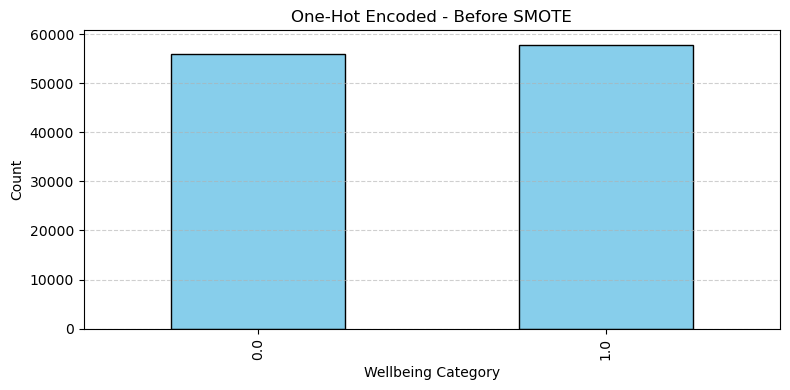

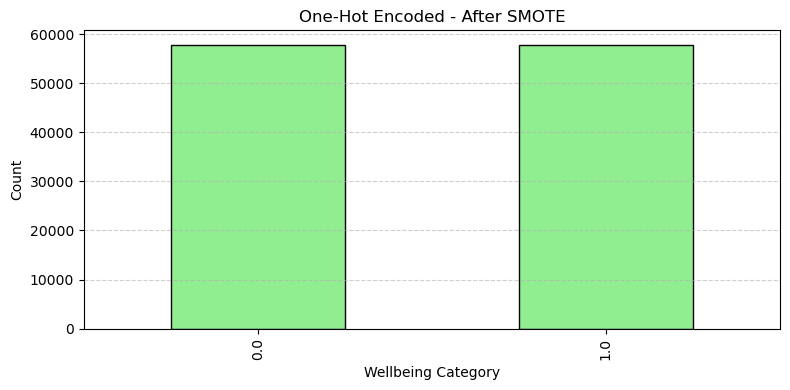

In [28]:
# --- Step 1: Copy and label-encode nominal columns ---
X_label = X.copy()
ordinal_encoder = OrdinalEncoder()
X_label[nominal_cols] = ordinal_encoder.fit_transform(X_label[nominal_cols])

# --- Step 2: Reuse train/val/test indices ---
X_train_idx = X_train.index
X_val_idx = X_val.index
X_test_idx = X_test.index

# --- Step 3: Scale continuous for label-encoded version ---
scaler_label = StandardScaler()
X_train_label_scaled_cont = scaler_label.fit_transform(X_label.loc[X_train_idx, continuous_cols])
X_val_label_scaled_cont = scaler_label.transform(X_label.loc[X_val_idx, continuous_cols])
X_test_label_scaled_cont = scaler_label.transform(X_label.loc[X_test_idx, continuous_cols])

# --- Step 4: Combine label-encoded features ---
X_train_label_final = np.hstack([
    X_train_label_scaled_cont,
    X_label.loc[X_train_idx, binary_cols].values,
    X_label.loc[X_train_idx, nominal_cols].values
])
X_val_label_final = np.hstack([
    X_val_label_scaled_cont,
    X_label.loc[X_val_idx, binary_cols].values,
    X_label.loc[X_val_idx, nominal_cols].values
])
X_test_label_final = np.hstack([
    X_test_label_scaled_cont,
    X_label.loc[X_test_idx, binary_cols].values,
    X_label.loc[X_test_idx, nominal_cols].values
])

# --- Step 5: Apply SMOTE to label-encoded set ---
smote_label = SMOTE(random_state=42)
X_train_label_resampled, y_train_label_resampled = smote_label.fit_resample(X_train_label_final, y_train)

# --- Step 6: Output shape summary ---
print(f"Train shape (original): {X_train_label_final.shape}")
print(f"Validation:             {X_val_label_final.shape}")
print(f"Test:                   {X_test_label_final.shape}")
print(f"Train shape (SMOTE):    {X_train_label_resampled.shape}")

# --- Step 7: Output distribution before & after SMOTE ---
print("\nWellbeing_category_num distribution in y_train (BEFORE SMOTE):")
print(y_train.value_counts(dropna=False).sort_index())

print("\nWellbeing_category_num distribution in y_train (AFTER SMOTE):")
print(pd.Series(y_train_resampled).value_counts().sort_index())

# --- Step 8: Visualize ---
plt.figure(figsize=(8, 4))
y_train.value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("One-Hot Encoded - Before SMOTE")
plt.xlabel("Wellbeing Category")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
pd.Series(y_train_resampled).value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("One-Hot Encoded - After SMOTE")
plt.xlabel("Wellbeing Category")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

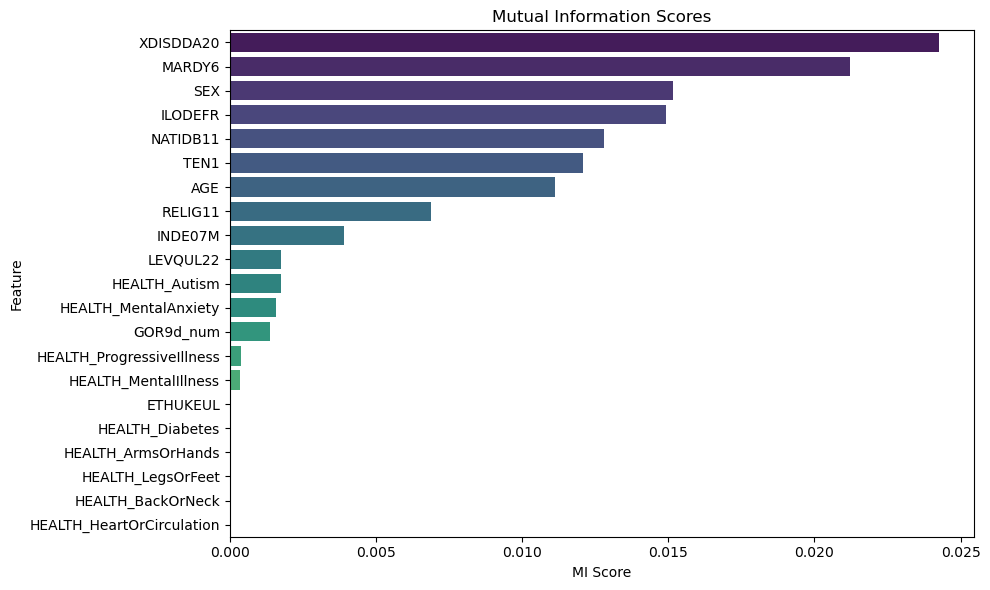

In [29]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
# --- Mutual Information Feature Importance ---
mi_scores = mutual_info_classif(X_label, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=mi_df,
    x='MI Score',
    y='Feature',
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## **Model building**


Model: Random Forest
Train Accuracy: 0.6266
Train ROC AUC: 0.6787
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60     57880
         1.0       0.61      0.68      0.65     57880

    accuracy                           0.63    115760
   macro avg       0.63      0.63      0.63    115760
weighted avg       0.63      0.63      0.63    115760



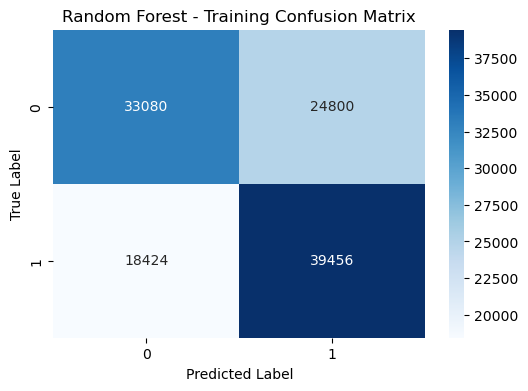

Test Accuracy: 0.6010
Test ROC AUC: 0.6438
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.54      0.57     11998
         1.0       0.60      0.66      0.63     12403

    accuracy                           0.60     24401
   macro avg       0.60      0.60      0.60     24401
weighted avg       0.60      0.60      0.60     24401



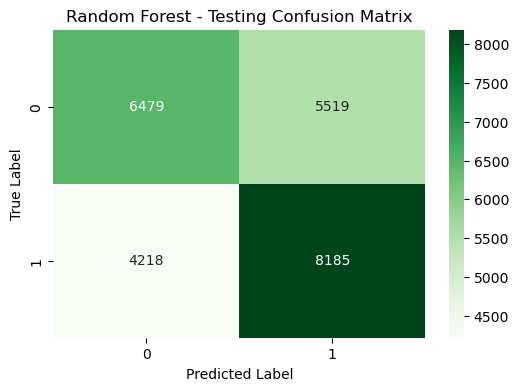


Model: XGBoost
Train Accuracy: 0.6358
Train ROC AUC: 0.6917
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.57      0.61     57880
         1.0       0.62      0.70      0.66     57880

    accuracy                           0.64    115760
   macro avg       0.64      0.64      0.63    115760
weighted avg       0.64      0.64      0.63    115760



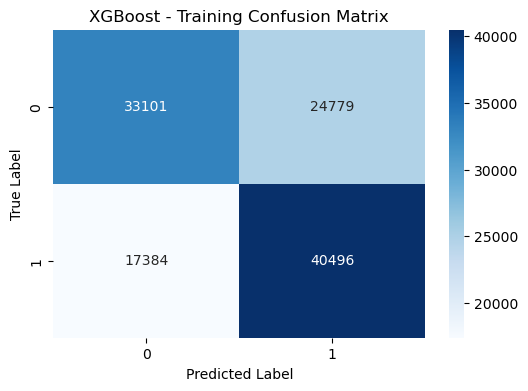

Test Accuracy: 0.6005
Test ROC AUC: 0.6381
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.53      0.57     11998
         1.0       0.60      0.67      0.63     12403

    accuracy                           0.60     24401
   macro avg       0.60      0.60      0.60     24401
weighted avg       0.60      0.60      0.60     24401



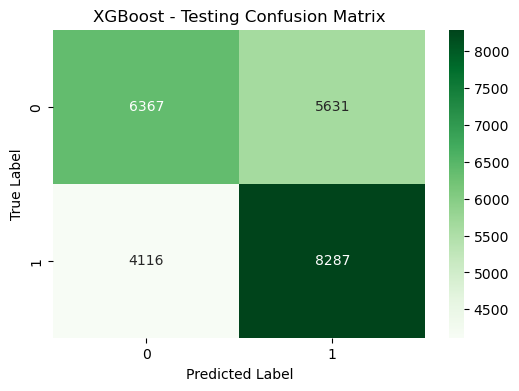


Model: LightGBM
[LightGBM] [Info] Number of positive: 57880, number of negative: 57880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 115760, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train Accuracy: 0.6217
Train ROC AUC: 0.6706
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.56      0.60     57880
         1.0       0.61      0.68      0.64     57880

    accuracy                           0.62    115760
   macro avg       0.62      0.62      0.62    115760
weighted avg       0.62      0.62      0.62    115760



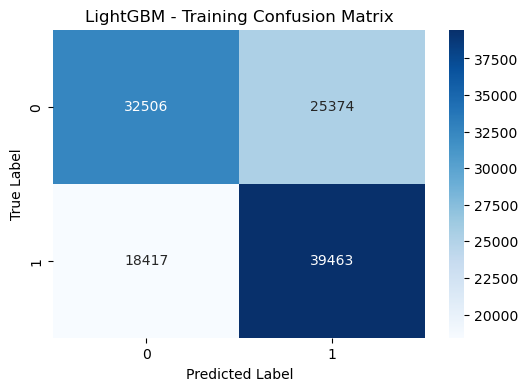

Test Accuracy: 0.6030
Test ROC AUC: 0.6444
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.53      0.57     11998
         1.0       0.60      0.67      0.63     12403

    accuracy                           0.60     24401
   macro avg       0.60      0.60      0.60     24401
weighted avg       0.60      0.60      0.60     24401



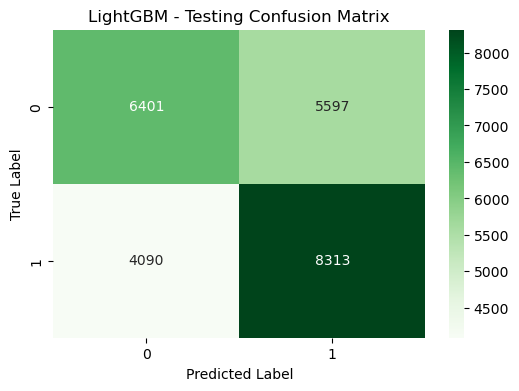


Model: Ridge Classifier
Train Accuracy: 0.5990
Train ROC AUC: 0.6387
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58     57880
         1.0       0.59      0.65      0.62     57880

    accuracy                           0.60    115760
   macro avg       0.60      0.60      0.60    115760
weighted avg       0.60      0.60      0.60    115760



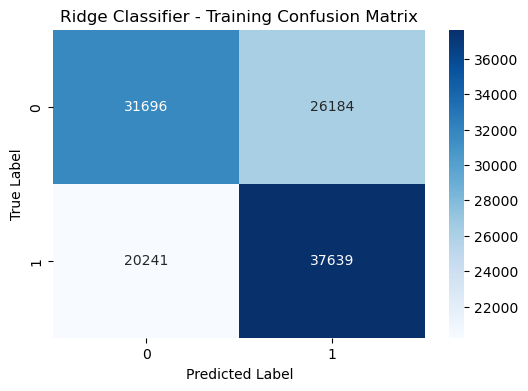

Test Accuracy: 0.5941
Test ROC AUC: 0.6326
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.54      0.57     11998
         1.0       0.59      0.64      0.62     12403

    accuracy                           0.59     24401
   macro avg       0.59      0.59      0.59     24401
weighted avg       0.59      0.59      0.59     24401



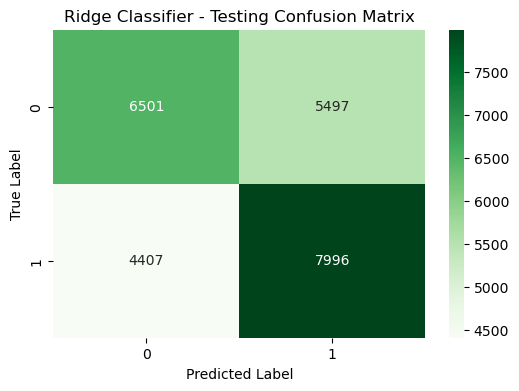

In [31]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Models that use label-encoded dataset ---
models_label = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'
    ),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    #"Support Vector Classifier": SVC(probability=True, random_state=42)
}


for name, model in models_label.items():
    print(f"\nModel: {name}")

    # Train
    model.fit(X_train_label_resampled, y_train_label_resampled)

    # Predict on training set
    y_pred_train = model.predict(X_train_label_resampled)

    # Get probabilities or decision scores for ROC AUC
    if hasattr(model, "predict_proba"):
        y_pred_train_proba = model.predict_proba(X_train_label_resampled)[:, 1]
    else:
        # Use decision_function for models without predict_proba (e.g., RidgeClassifier)
        y_pred_train_proba = model.decision_function(X_train_label_resampled)

    acc_train = accuracy_score(y_train_label_resampled, y_pred_train)
    roc_auc_train = roc_auc_score(y_train_label_resampled, y_pred_train_proba)

    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Train ROC AUC: {roc_auc_train:.4f}")
    print("Training Classification Report:")
    print(classification_report(y_train_label_resampled, y_pred_train))

    cm_train = confusion_matrix(y_train_label_resampled, y_pred_train)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Training Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Predict on test set
    y_pred_test = model.predict(X_test_label_final)

    if hasattr(model, "predict_proba"):
        y_pred_test_proba = model.predict_proba(X_test_label_final)[:, 1]
    else:
        y_pred_test_proba = model.decision_function(X_test_label_final)

    acc_test = accuracy_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

    print(f"Test Accuracy: {acc_test:.4f}")
    print(f"Test ROC AUC: {roc_auc_test:.4f}")
    print("Testing Classification Report:")
    print(classification_report(y_test, y_pred_test))

    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} - Testing Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Model: Logistic Regression
Training Performance:
              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59     57880
         1.0       0.60      0.65      0.62     57880

    accuracy                           0.61    115760
   macro avg       0.61      0.61      0.60    115760
weighted avg       0.61      0.61      0.60    115760

Train ROC AUC: 0.6458


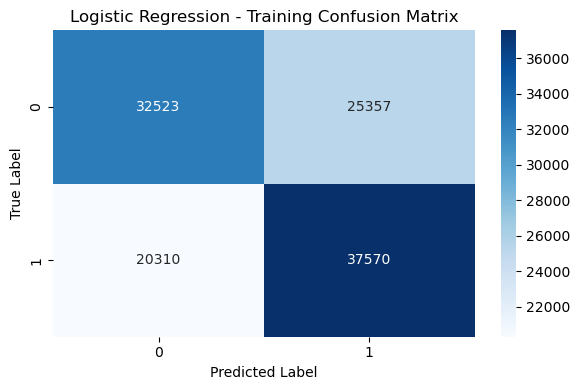

Testing Performance:
              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58     11998
         1.0       0.60      0.64      0.62     12403

    accuracy                           0.60     24401
   macro avg       0.60      0.60      0.60     24401
weighted avg       0.60      0.60      0.60     24401

Test ROC AUC: 0.6412


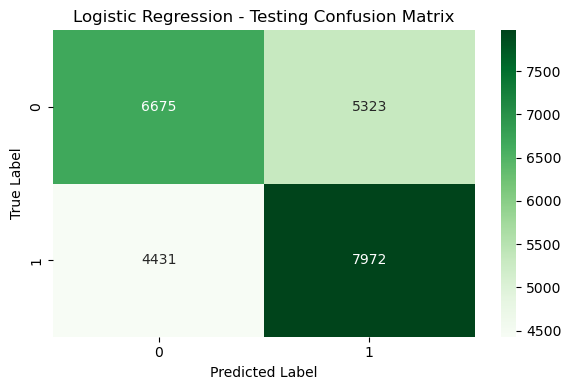


Model: K-Nearest Neighbors
Training Performance:
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68     57880
         1.0       0.68      0.69      0.69     57880

    accuracy                           0.68    115760
   macro avg       0.68      0.68      0.68    115760
weighted avg       0.68      0.68      0.68    115760

Train ROC AUC: 0.7408


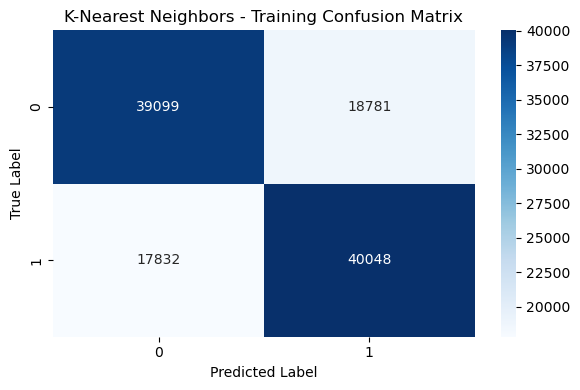

Testing Performance:
              precision    recall  f1-score   support

         0.0       0.55      0.55      0.55     11998
         1.0       0.57      0.57      0.57     12403

    accuracy                           0.56     24401
   macro avg       0.56      0.56      0.56     24401
weighted avg       0.56      0.56      0.56     24401

Test ROC AUC: 0.5767


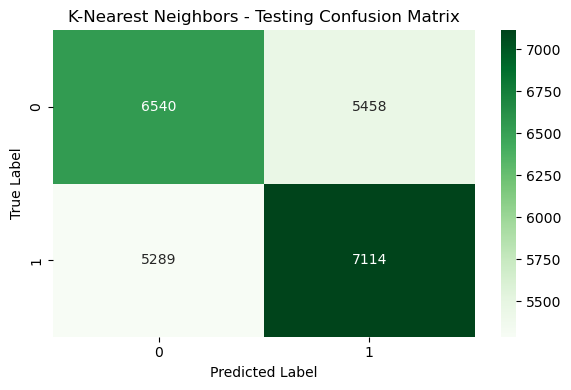


Model: Neural Network (MLP)
Training Performance:
              precision    recall  f1-score   support

         0.0       0.70      0.58      0.64     57880
         1.0       0.64      0.75      0.69     57880

    accuracy                           0.67    115760
   macro avg       0.67      0.67      0.66    115760
weighted avg       0.67      0.67      0.66    115760

Train ROC AUC: 0.7366


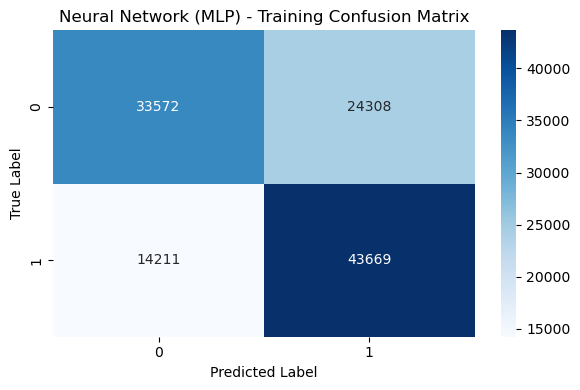

Testing Performance:
              precision    recall  f1-score   support

         0.0       0.59      0.49      0.53     11998
         1.0       0.57      0.67      0.62     12403

    accuracy                           0.58     24401
   macro avg       0.58      0.58      0.58     24401
weighted avg       0.58      0.58      0.58     24401

Test ROC AUC: 0.6016


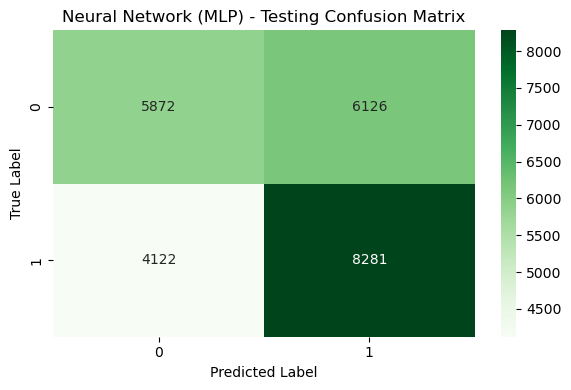

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# List of models to test
models_onehot = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}


for name, model in models_onehot.items():
    print(f"\nModel: {name}")
    
    # Train
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on training set
    y_pred_train = model.predict(X_train_resampled)
    y_pred_train_proba = model.predict_proba(X_train_resampled)[:, 1]  # probability of class 1
    
    roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train_proba)
    
    print("Training Performance:")
    print(classification_report(y_train_resampled, y_pred_train))
    print(f"Train ROC AUC: {roc_auc_train:.4f}")

    # Confusion matrix for training set
    cm_train = confusion_matrix(y_train_resampled, y_pred_train)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Training Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Predict on test set
    y_pred_test = model.predict(X_test_scaled)
    y_pred_test_proba = model.predict_proba(X_test_scaled)[:, 1]

    roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)
    
    print("Testing Performance:")
    print(classification_report(y_test, y_pred_test))
    print(f"Test ROC AUC: {roc_auc_test:.4f}")

    # Confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} - Testing Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [33]:
import pandas as pd
from sklearn.metrics import f1_score

# Store results here
results_summary = []

# --- Label-encoded models ---
for name, model in models_label.items():
    # Train set metrics
    y_pred_train = model.predict(X_train_label_resampled)
    if hasattr(model, "predict_proba"):
        y_pred_train_proba = model.predict_proba(X_train_label_resampled)[:, 1]
    else:
        y_pred_train_proba = model.decision_function(X_train_label_resampled)

    acc_train = accuracy_score(y_train_label_resampled, y_pred_train)
    f1_train = f1_score(y_train_label_resampled, y_pred_train, average='weighted')
    roc_auc_train = roc_auc_score(y_train_label_resampled, y_pred_train_proba)

    # Test set metrics
    y_pred_test = model.predict(X_test_label_final)
    if hasattr(model, "predict_proba"):
        y_pred_test_proba = model.predict_proba(X_test_label_final)[:, 1]
    else:
        y_pred_test_proba = model.decision_function(X_test_label_final)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

    # Save to summary
    results_summary.append({
        "Encoding": "Label Encoded",
        "Model": name,
        "Train Accuracy": acc_train,
        "Train F1": f1_train,
        "Train ROC AUC": roc_auc_train,
        "Test Accuracy": acc_test,
        "Test F1": f1_test,
        "Test ROC AUC": roc_auc_test
    })

# --- One-hot encoded models ---
for name, model in models_onehot.items():
    # Train set metrics
    y_pred_train = model.predict(X_train_resampled)
    y_pred_train_proba = model.predict_proba(X_train_resampled)[:, 1]
    acc_train = accuracy_score(y_train_resampled, y_pred_train)
    f1_train = f1_score(y_train_resampled, y_pred_train, average='weighted')
    roc_auc_train = roc_auc_score(y_train_resampled, y_pred_train_proba)

    # Test set metrics
    y_pred_test = model.predict(X_test_scaled)
    y_pred_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

    # Save to summary
    results_summary.append({
        "Encoding": "One-Hot Encoded",
        "Model": name,
        "Train Accuracy": acc_train,
        "Train F1": f1_train,
        "Train ROC AUC": roc_auc_train,
        "Test Accuracy": acc_test,
        "Test F1": f1_test,
        "Test ROC AUC": roc_auc_test
    })

# --- Create and show DataFrame ---
df_results = pd.DataFrame(results_summary)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n=== Model Performance Summary ===")
print(df_results)


=== Model Performance Summary ===
          Encoding                 Model  Train Accuracy  Train F1  \
0    Label Encoded         Random Forest          0.6266    0.6255   
1    Label Encoded               XGBoost          0.6358    0.6343   
2    Label Encoded              LightGBM          0.6217    0.6203   
3    Label Encoded      Ridge Classifier          0.5990    0.5979   
4  One-Hot Encoded   Logistic Regression          0.6055    0.6048   
5  One-Hot Encoded   K-Nearest Neighbors          0.6837    0.6837   
6  One-Hot Encoded  Neural Network (MLP)          0.6673    0.6647   

   Train ROC AUC  Test Accuracy  Test F1  Test ROC AUC  
0         0.6787         0.6010   0.5995        0.6438  
1         0.6917         0.6005   0.5986        0.6381  
2         0.6706         0.6030   0.6011        0.6444  
3         0.6387         0.5941   0.5930        0.6326  
4         0.6458         0.6003   0.5995        0.6412  
5         0.7408         0.5596   0.5595        0.5767  
6    